# Environment setting

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=b8b50cfea79c28037e66ac9bd44394c02b3db0e14e595a2eb44abe9f8654ddb9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded = drive.CreateFile({'id':'13RZ0_sSr5HbTm1urv5veWtuRWkWoxbDA'}) # replace the id with id of file you want to access
downloaded.GetContentFile('data.py')

In [7]:
% run data.py

In [8]:
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)

In [9]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


#Train,Test data tidyup (Batch size setting, Padding)

In [45]:
batch = []
target = []
for j in range(500):
    tensor_x = []
    for i in range(40):
        tensor_x.append(torch.tensor(x_train[i+j*40], dtype=torch.long))
    tensor_pad = pad_sequence(tensor_x, batch_first=True, padding_value=0)
    batch.append(tensor_pad)
    target.append(torch.tensor(y_train[0+j*40:40+j*40]))

In [46]:
v_batch = []
v_target = []
for j in range(125):
    tensor_x = []
    for i in range(40):
        tensor_x.append(torch.tensor(x_train[i+j*40], dtype=torch.long))
    tensor_pad = pad_sequence(tensor_x, batch_first=True, padding_value=0)
    v_batch.append(tensor_pad)
    v_target.append(torch.tensor(y_train[0+j*40:40+j*40]))

# Model 1: Handmade No-reccurrent NN

In [47]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 16 output channels, 3x3 square convolution
        # kernel
        self.layer1 = nn.Embedding(len(i2w),300)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(300,300)  
        self.fc2 = nn.Linear(300,2)

    def forward(self, x):
        x = self.layer1(x.to(device))
        x = torch.max(F.relu(self.fc1(x.to(device))),1)
        x = self.fc2(x.values)
        return x

net = Net()
print(net)

Net(
  (layer1): Embedding(99430, 300)
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=2, bias=True)
)


In [48]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(),betas=(0.9, 0.999), lr=0.0005)

In [49]:
accuracy_NoRecurrent = []
for epoch in range(35): 
  running_loss = 0.0
  for j in range(500):
    outputs = net.to(device)(batch[j].to(device))
    optimizer.zero_grad()
    loss = torch.nn.functional.cross_entropy(F.softmax(outputs,1),target[j].to(device))
    loss.backward()
    optimizer.step() 
 
  correct = 0
  total = 0
  with torch.no_grad():
      for j in range(125):
          outputs = net(v_batch[j].to(device))
          _, predicted = torch.max(outputs.data, 1)
          total += v_target[j].size(0)
          correct += (predicted == v_target[j].to(device)).sum().item()

  accuracy = correct/total
  print(accuracy)
  accuracy_NoRecurrent.append(accuracy) 
print('Finished Training')

0.8812
0.913
0.9364
0.953
0.9656
0.9714
0.9754
0.9652
0.9318
0.9428
0.9874
0.9894
0.9902
0.9914
0.987
0.9916
0.9926
0.993
0.9934
0.9936
0.9936
0.9944
0.9822
0.9948
0.9944
0.9952
0.9954
0.9956
0.9956
0.9956
0.994
0.9954
0.9956
0.9958
0.9958
Finished Training


# Model 2: Elman 

In [15]:
class Elman (nn.Module):
    def __init__ (self , insize= 300 , outsize= 300 , hsize= 300 ):
        super (). __init__ ()
        self.lin1 = nn.Linear(insize+hsize,hsize)  
        self.lin2 = nn.Linear(hsize,outsize)
    def forward (self , x, hidden= None ):
        b, t, e = x.size()
        if hidden is None :
            hidden = torch.zeros(b, e, dtype =torch.float)
        outs = []
        
        for i in range (t):
            inp = torch.cat([x[:, i, :], hidden.to(device)], dim = 1)
            inp = F.relu(self.lin1(inp)) 
            out = self.lin2(inp)
            outs.append(out[:, None , :])
        return torch.cat(outs, dim = 1 ), hidden

In [16]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 16 output channels, 3x3 square convolution
        # kernel
        self.layer1 = nn.Embedding(len(i2w),300)
        # an affine operation: y = Wx + b
        self.fc1 = Elman(300,300,300) 
        self.fc2 = nn.Linear(300,2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.fc1(x)
        x = torch.max(F.relu(x[0]),1)
        x = self.fc2(x.values)
        return x

net_Elman = Net()
print(net_Elman)

Net(
  (layer1): Embedding(99430, 300)
  (fc1): Elman(
    (lin1): Linear(in_features=600, out_features=300, bias=True)
    (lin2): Linear(in_features=300, out_features=300, bias=True)
  )
  (fc2): Linear(in_features=300, out_features=2, bias=True)
)


In [17]:
optimizer = optim.Adam(net_Elman.parameters(),betas=(0.9, 0.999), lr=0.001)

In [18]:
for epoch in range(1): 
    running_loss = 0.0 
    for j in range(500):
        outputs = net_Elman.to(device)(batch[j].to(device))
        optimizer.zero_grad()
        loss = torch.nn.functional.cross_entropy(F.softmax(outputs,1),target[j].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if j % 50 == 49:    # print every 2000 mini-batches
          print('[%5d] loss: %.3f' %
          (j + 1, running_loss / 50))
          running_loss = 0.0 

print('Finished Training')

[   50] loss: 0.597
[  100] loss: 0.476
[  150] loss: 0.488
[  200] loss: 0.460
[  250] loss: 0.448
[  300] loss: 0.446
[  350] loss: 0.502
[  400] loss: 0.481
[  450] loss: 0.507
[  500] loss: 0.474
Finished Training


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for j in range(125):
        outputs = net(v_batch[j].to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += v_target[j].size(0)
        correct += (predicted == v_target[j].to(device)).sum().item()

print('Accuracy of the network on the 5000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 5000 test images: 80 %


# Model 3: Recurrent NN

In [50]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 16 output channels, 3x3 square convolution
        # kernel
        self.layer1 = nn.Embedding(len(i2w),300)
        # an affine operation: y = Wx + b
        self.fc1 = nn.RNN(300,300) 
        self.fc2 = nn.Linear(300,2)

    def forward(self, x):
        x = self.layer1(x.to(device))
        x = self.fc1(x.to(device))
        x = torch.max(F.relu(x[0].to(device)),1)
        x = self.fc2(x.values)
        return x

net_Rnn = Net()
print(net_Rnn)

Net(
  (layer1): Embedding(99430, 300)
  (fc1): RNN(300, 300)
  (fc2): Linear(in_features=300, out_features=2, bias=True)
)


In [51]:
optimizer = optim.Adam(net_Rnn.parameters(),betas=(0.9, 0.999), lr=0.0005)

In [52]:
accuracy_RNN = []
for epoch in range(35):
    running_loss = 0.0 
    for j in range(500):
        outputs = net_Rnn.to(device)(batch[j].to(device))
        optimizer.zero_grad()
        loss = torch.nn.functional.cross_entropy(F.softmax(outputs,1),target[j].to(device))
        loss.backward()
        optimizer.step()
    correct = 0
    total = 0
    with torch.no_grad():
        for j in range(125):
            outputs = net_Rnn(v_batch[j].to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += v_target[j].size(0)
            correct += (predicted == v_target[j].to(device)).sum().item()

    accuracy = correct/total
    print(accuracy)
    accuracy_RNN.append(accuracy) 
print('Finished Training')

0.8214
0.8826
0.9028
0.9216
0.931
0.9404
0.9434
0.946
0.9472
0.9506
0.954
0.9592
0.9582
0.9496
0.973
0.9742
0.9748
0.9828
0.9862
0.9902
0.9772
0.9886
0.9928
0.993
0.9954
0.9924
0.991
0.99
0.9904
0.9928
0.9922
0.996
0.995
0.9958
0.9974
Finished Training


# Model 4: LSTM

In [22]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 16 output channels, 3x3 square convolution
        # kernel
        self.layer1 = nn.Embedding(len(i2w),300)
        # an affine operation: y = Wx + b
        self.fc1 = nn.LSTM(300,300)  
        self.fc2 = nn.Linear(300,2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.fc1(x)
        x = torch.max(F.relu(x[0]),1)
        x = self.fc2(x.values)
        return x

net_LSTM = Net()
print(net_LSTM)

Net(
  (layer1): Embedding(99430, 300)
  (fc1): LSTM(300, 300)
  (fc2): Linear(in_features=300, out_features=2, bias=True)
)


In [20]:
optimizer = optim.Adam(net_LSTM.parameters(),betas=(0.9, 0.999), lr=0.0005)

In [21]:
accuracy_LSTM = []
for epoch in range(35): 
    running_loss = 0.0
    for j in range(500):
        outputs = net_LSTM.to(device)(batch[j].to(device))
        optimizer.zero_grad()
        loss = torch.nn.functional.cross_entropy(F.softmax(outputs,1),target[j].to(device))
        loss.backward()
        optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
       for j in range(125):
         outputs = net_LSTM(v_batch[j].to(device))
         _, predicted = torch.max(outputs.data, 1)
         total += v_target[j].size(0)
         correct += (predicted == v_target[j].to(device)).sum().item()

    accuracy = correct/total
    print(accuracy)
    accuracy_LSTM.append(accuracy) 
print('Finished Training')

0.678
0.7916
0.802
0.8072
0.8042
0.807
0.866
0.907
0.8326
0.87
0.958
0.977
0.9834
0.9806
0.9946
0.9986
0.998
0.9994
0.999
0.9986
0.9994
0.9994
0.9994
0.999
0.9992
0.9994
0.9994
0.9994
0.9994
0.9994
0.9994
0.9994
0.9994
0.9994
0.9994
Finished Training


# Accuarcy plot

In [53]:
import matplotlib.pyplot as plt

In [65]:
epochs = np.arange(35)+1

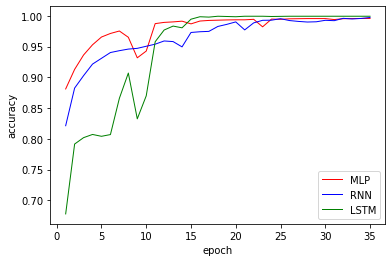

In [68]:
plt.plot(epochs,np.array(accuracy_NoRecurrent), color = 'red', linewidth = 1,alpha=1)             
plt.plot(epochs,np.array(accuracy_RNN), color =  'blue', linewidth = 1,alpha=1) 
plt.plot(epochs,np.array(accuracy_LSTM), color = 'green', linewidth = 1,alpha=1) 
plt.xlabel("epoch")
plt.ylabel("accuracy")    
plt.legend(['MLP', 'RNN','LSTM'], loc=4)        
plt.show()

In [62]:
np.array(35)

array(35)